# Trimming Propensity Scores based on Placebo Results
Julian Hsu
25-dec-2023

The purpose of this script is to show we can validate how much to trim propensity scores based on how they estimate a placebo result. We also want to show that this placebo result needs to be correlated with our outcome of interest, rather than a random number.

In [284]:
import stnomics as st
import numpy as np
import pandas as pd

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.conditional_models import ConditionalLogit

from IPython.display import display    


import scipy.stats 

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error



## DGP Function
We want to make sure that we have plenty of extreme propensity scores, which will necessitate our use of propensity trimming.

In [415]:
def data_gp(N=1000, te=1):
    
        
    ## Make one variable a lognormal distribution to make sure we have extreme propensity scores
    x0 = np.abs(np.random.normal(0,1,N) )
    
    df = pd.DataFrame(data={'x0':x0})
    x_list = [e for e in df.columns if 'x' in e]    
    
    ## Assign treatment status    
    ## Make each feature substnatially significant, so don't let them center around zero
    latent_w = np.random.uniform(0,1)*df['x0']+ np.random.normal(0,3,N)
    latent_w = np.exp(latent_w) / (1 + np.exp(latent_w))
    df['latent_w'] = latent_w
    
    df['w'] = (df['latent_w']  + np.random.uniform(-1,1,N) > df['latent_w'].quantile(0.5) ).astype(float)        

    
    ## Assign outcome
    ## Make each feature substnatially significant, so don't let them center around zero
    random = np.random.uniform(0,1)
    if random > 0.5:
        df['y'] = df['x0']*np.random.uniform(-3,-2) + np.random.normal(0,1,N)
    else:
        df['y'] = df['x0']*np.random.uniform(2,3) + np.random.normal(0,1,N)

    df['y_0'] = df['y'].values
    df['y'] += df['w']*te
    df['random'] = np.random.normal(0,1,N)
    
    return df

In [411]:
def ipw_estimate(data=df, pscore=None, outcome=None, treatment='w'):
    treat_weighted = data.loc[data[treatment]==1][outcome] /data.loc[data[treatment]==1][pscore]
    control_weighted = data.loc[data[treatment]==0][outcome] /(1-data.loc[data[treatment]==0][pscore])
    return np.average(treat_weighted) - np.average(control_weighted)

In [83]:
df_results = pd.DataFrame()

for s in range(100):
    df = data_gp(te=2)
    
    for outcome in ['y','y_0','random']:
        a=ipw_estimate(data=df.loc[df['latent_w'].between(0,1)]
                       , pscore='latent_w',outcome=outcome)
        b=ipw_estimate(data=df.loc[df['latent_w'].between(0.0001,0.9999)]
                       , pscore='latent_w',outcome=outcome)
        c=ipw_estimate(data=df.loc[df['latent_w'].between(0.01,0.99)]
                       , pscore='latent_w',outcome=outcome)
        row = pd.DataFrame(index=[0],data={'outcome':outcome, 'all':a, 'between_0.01_0.99':c})
        row['sim']=s
        df_results=pd.concat([df_results,row])

In [84]:
df_results

,outcome,all,between_0.01_0.99,sim
0,y,-27.239314,-20.196751,0
0,y_0,-30.570761,-23.582302,0
0,random,1.546912,0.770017,0
0,y,26.824387,16.237308,1
0,y_0,22.669703,12.055297,1
...,...,...,...,...
0,y_0,-25.923395,-22.252709,98
0,random,-0.607089,-0.699088,98
0,y,-40.585238,-13.172418,99
0,y_0,-44.773789,-17.415799,99


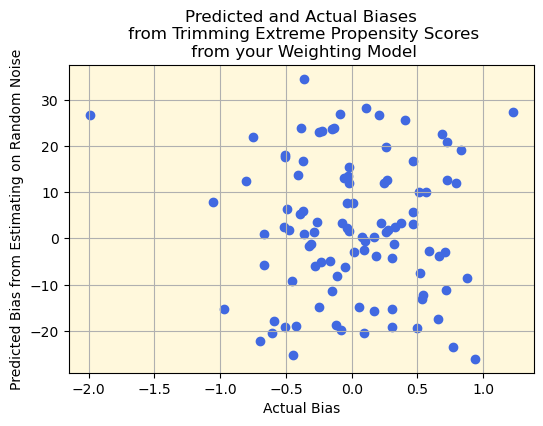

<Figure size 640x480 with 0 Axes>

In [90]:
fig,ax = plt.subplots(ncols=1,nrows=1,figsize=(6,4))
ax.scatter(df_results.loc[df_results['outcome']=='random']['between_0.01_0.99']
          , df_results.loc[df_results['outcome']=='y_0']['between_0.01_0.99']
          , color='royalblue')
ax.set_xlabel('Actual Bias')
ax.set_ylabel('Predicted Bias from Estimating on Random Noise')
ax.set_title('Predicted and Actual Biases\n from Trimming Extreme Propensity Scores\n from your Weighting Model')
ax.set_facecolor('cornsilk')
ax.grid()
plt.show()
plt.tight_layout()
